# Imports 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

# Helper Functions

In [2]:
def get_data(num_points=100, shape='8'):

    if shape == '8':
        # Generate a dataset in the shape of "8"
        t = np.linspace(0, 2 * np.pi, num_points)
        x = np.sin(t)
        y = np.sin(t) * np.cos(t)

        # Add some noise to the data
        noise = 0.01 * np.random.randn(len(t))
        x += noise
        y += noise
        
    elif shape=='flower':
        
        # Create a flower-like dataset
        theta = np.linspace(0, 2*np.pi, num_points)
        r = np.sin(5*theta) + 0.2 * np.random.rand(len(theta))

        x = r * np.cos(theta)
        y = r * np.sin(theta)
    
    elif shape=='parabola':
        
        # Generate a dataset in the shape of "8"
        t = np.linspace(-1, 1, num_points)
        x = t
        y = t**2

        # Add some noise to the data
        noise = 0.01 * np.random.randn(len(t))
        x += noise
        y += noise
    

        
        
    # Convert the NumPy arrays to Torch tensors and stack them horizontally
    data = torch.tensor([x, y], dtype=torch.float32)
    
    return data.T


In [54]:
def visualise_mainfold(data):
    
    # Plot the dataset
    x = data[:, 0]
    y = data[:, 1]
    plt.grid()
    plt.scatter(x, y, marker='.', c='crimson')
    plt.title('2D Dataset Mainfold')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')  
    plt.show()

In [55]:
def visualise_generation(data_list):
    
    # Create a figure with 5 subplots arranged vertically
    plt.figure(figsize=(15, 3))

    for idx, d in enumerate(data_list):
    
        plt.subplot(1, 5, idx+1)
        plt.scatter(d[:, 0], d[:, 1], marker='.', c='crimson')
        plt.title('Image Mainfold')
        plt.grid()
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.axis('equal') 
    
    
    
    
    #plt.scatter(x, y, marker='.', c='crimson')
   # plt.title('Reverse Process Visualised')
     
    plt.show()

/tmp/ipykernel_41614/2153246443.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data = torch.tensor([x, y], dtype=torch.float32)


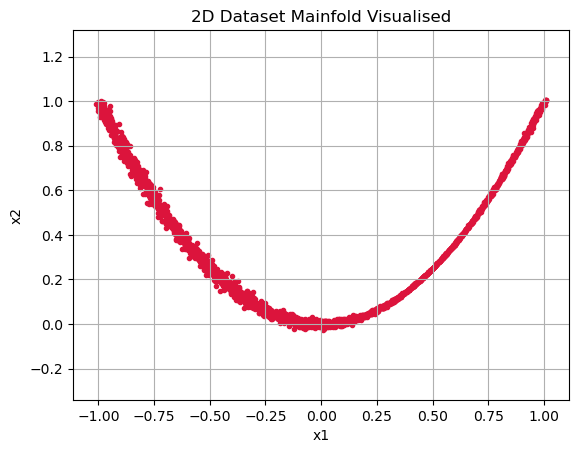

In [5]:
data = get_data(num_points=2000, shape='parabola')
visualise_mainfold(data)

In [6]:
def generate_new_sample(alpha, alpha_bar, sigma, net, T=100, num_samples=50, input_dim=2):

    # Store all the samples in the difussion process in X
    X = torch.zeros((T+1, num_samples, input_dim)) 
    # # Last step sample X[T] is pure gaussian noise
    X[T] = torch.randn((num_samples, input_dim)) 
    # Reverse Process 
    for t in range(T, 0, -1):

        if t!=1:
            Z = torch.randn((num_samples, input_dim))
        else:
            Z = torch.zeros((num_samples, input_dim))
        
        T_vec =  torch.full((num_samples, 1), t)
        X[t-1] = X[t] - ((1-alpha[t])/torch.sqrt(1-alpha_bar[t]))*net(X[t], T_vec)
        X[t-1] = (1/torch.sqrt(alpha[t]))*X[t-1] + sigma[t]*Z
    
    return X

## Neural net definition

In [7]:
class EpsNet(nn.Module):
    def __init__(self,input_dim=7, T=1000):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=64)
        self.layer_2 = nn.Linear(64,64)
        self.layer_3 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Dropout probability of 0.5
        self.T = T
        
        
    def forward(self, X, t):
        
        t = torch.cat(((t/self.T)**0.3, (t/self.T)**0.5,t/self.T,(t/self.T)**2, (t/self.T)**2),-1)
        
        X_ = torch.cat((X,t), -1)
        
        out = self.layer_1(X_)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        #out = 3*self.relu(out)
        
        return out + X 

# Model Definition and Parameters

In [8]:
T = 4000  # T is number of diffusion steps
input_dim = data.shape[1]# the dimeinsions of input samples
batch_size = 100
num_epochs = 10000
num_batches = len(data)//batch_size

In [9]:
model = EpsNet(input_dim=7, T=T)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [10]:
beta = torch.linspace(0.0,.999,T+1)
alpha = 1-beta
sigma = torch.sqrt(beta)
alpha_bar = torch.cumprod(alpha, dim=0) # cumlative product

# Training

In [11]:
eloss_list = []

In [12]:
# sample batch 
for epoch in range(1,num_epochs+1):
    running_loss = 0
    for batch in range(1,num_batches+1):
        random_indices = np.random.choice(len(data), batch_size, replace=False)
        X = data[random_indices]

        t = torch.randint(1,T+1,size = [batch_size,1])

        noise = torch.randn((batch_size,input_dim))

        X_t = torch.sqrt(alpha_bar[t])*X + torch.sqrt(1-alpha_bar[t])*noise

        # 1. forward pass
        y_pred = model(X_t, t)
        # 2. loss calculation
        loss = criterion(y_pred,noise)
        # 3. Clear up the gradients
        optimizer.zero_grad()
        # 4. back propagations
        loss.backward()
        # 5. gradient descents
        optimizer.step()
    
        running_loss += loss.item()*len(X)
    
    epoch_loss = running_loss/len(data)
    eloss_list.append(epoch_loss)
    
    if epoch%50==0:
        print(f"epoch{epoch}-----{epoch_loss}")
        eloss_list.append(loss.item())

epoch50-----0.013000755879329518
epoch100-----0.007744759414345026
epoch150-----0.014481642015744001
epoch200-----0.009523638460086659
epoch250-----0.009823859779862687
epoch300-----0.008822053455514834
epoch350-----0.004864193990215426
epoch400-----0.006243897237436613
epoch450-----0.008638668483536093
epoch500-----0.005077389947837218
epoch550-----0.008545856375712901
epoch600-----0.005726779386895942
epoch650-----0.01075960631860653
epoch700-----0.007997404470370385
epoch750-----0.007797205901442794
epoch800-----0.01729405407095328
epoch850-----0.008269789521727943
epoch900-----0.009359499799120385
epoch950-----0.004406713298521936
epoch1000-----0.00635544656397542
epoch1050-----0.009188696095952765
epoch1100-----0.008907785257906652
epoch1150-----0.01224144225125201
epoch1200-----0.011181144705619771
epoch1250-----0.008528125398879639
epoch1300-----0.009586374579885159
epoch1350-----0.006304305158846546
epoch1400-----0.012176790049124975
epoch1450-----0.006888875227014068
epoch1500

KeyboardInterrupt: 

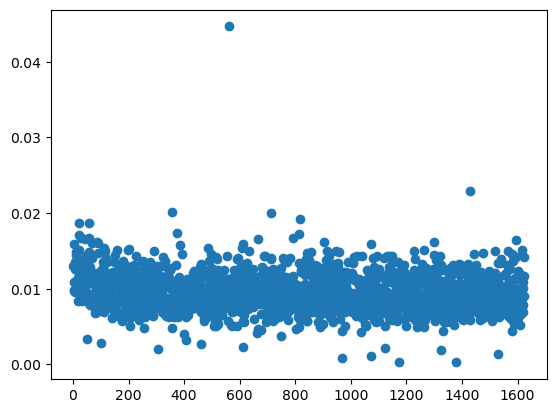

In [13]:
x = np.arange(len(eloss_list))+1

y = np.array(eloss_list)
plt.scatter(x, y)
plt.show()

In [14]:
X_gen = generate_new_sample(alpha=alpha, alpha_bar=alpha_bar, sigma=sigma, 
               net=model, T=T, num_samples=400, input_dim=2)

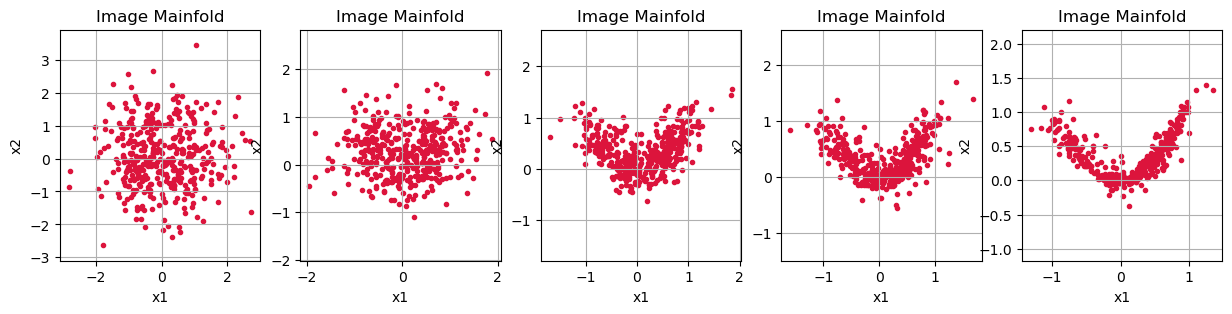

In [63]:
visualise_generation([X_gen[200].detach(), X_gen[35].detach(), X_gen[15].detach(), 
                    X_gen[8].detach(), X_gen[0].detach()])

In [17]:
X_gen.shape

torch.Size([4001, 400, 2])